In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

nx.__version__

In [29]:
plt.rcParams["figure.figsize"] = [18, 15]

## Data

In [5]:
data = pd.read_parquet("../data/graph_network/airlines_graph.parquet")
data.shape

data

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance
0,2013,2,26,1807,1630,97,1956,1837,79,EV,4411,N13566,EWR,MEM,144,946
1,2013,8,17,1459,1445,14,1801,1747,14,B6,1171,N661JB,LGA,FLL,147,1076
2,2013,2,13,1812,1815,-3,2055,2125,-30,AS,7,N403AS,EWR,SEA,315,2402
3,2013,4,11,2122,2115,7,2339,2353,-14,B6,97,N656JB,JFK,DEN,221,1626
4,2013,8,5,1832,1835,-3,2145,2155,-10,AA,269,N3EYAA,JFK,SEA,358,2422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013,11,29,1129,1135,-6,1414,1436,-22,DL,1875,N342NB,LGA,TPA,147,1010
96,2013,3,10,1029,1029,0,1300,1344,-44,UA,1605,N37465,EWR,LAX,308,2454
97,2013,11,25,1724,1725,-1,1828,1845,-17,AA,256,N3CTAA,JFK,BOS,40,187
98,2013,3,5,930,929,1,1421,1426,-5,B6,215,N638JB,EWR,SJU,200,1608


### Reformat Time Columns

In [4]:
# Check for missing values
data[
    ["sched_dep_time", "sched_arr_time", "dep_time", "arr_time", "year", "month", "day"]
].isna().sum()

sched_dep_time    0
sched_arr_time    0
dep_time          1
arr_time          1
year              0
month             0
day               0
dtype: int64

In [5]:
data["std"] = pd.to_datetime(data.sched_dep_time, format="%H%M").dt.strftime("%H:%M:%S")
data["std"].sample(10)

40    08:30:00
69    18:35:00
70    15:20:00
64    11:15:00
82    15:20:00
11    09:12:00
45    12:00:00
0     16:30:00
29    20:40:00
49    17:15:00
Name: std, dtype: object

In [6]:
data["sta"] = pd.to_datetime(data.sched_arr_time, format="%H%M").dt.strftime("%H:%M:%S")
data["sta"].sample(10)

32    21:32:00
70    17:05:00
73    15:39:00
43    13:39:00
37    11:00:00
54    12:05:00
81    16:30:00
84    21:30:00
39    23:59:00
98    14:26:00
Name: sta, dtype: object

In [7]:
data["atd"] = pd.to_datetime(data.dep_time, format="%H%M").dt.strftime("%H:%M:%S")
data["atd"].sample(10)

79    07:21:00
82    15:17:00
71    05:59:00
97    17:24:00
75    19:39:00
4     18:32:00
1     14:59:00
19    06:39:00
73    13:37:00
86    17:30:00
Name: atd, dtype: object

In [8]:
# Special case in 'arr_time' where time is a single digit == 9
data.loc[data.arr_time == 9, "arr_time"] = 900

data["ata"] = pd.to_datetime(data.arr_time, format="%H%M").dt.strftime("%H:%M:%S")
data["ata"].sample(10)

29    23:59:00
86    20:41:00
97    18:28:00
63    23:45:00
61    10:02:00
5     17:51:00
76    19:57:00
90    09:00:00
22    17:43:00
77    16:39:00
Name: ata, dtype: object

In [9]:
data["date"] = pd.to_datetime(data[["year", "month", "day"]])
data.drop(columns=["year", "month", "day"], axis=1, inplace=True)
data["date"].sample(10)

0    2013-02-26
50   2013-07-02
53   2013-03-21
18   2013-01-02
76   2013-02-18
2    2013-02-13
28   2013-01-30
38   2013-07-01
91   2013-07-29
85   2013-07-01
Name: date, dtype: datetime64[ns]

In [10]:
# Check for missing after conversions
data[["sched_dep_time", "sched_arr_time", "dep_time", "arr_time", "date"]].isna().sum()

sched_dep_time    0
sched_arr_time    0
dep_time          1
arr_time          1
date              0
dtype: int64

In [11]:
# Drop original time columns
data.drop(
    ["sched_dep_time", "sched_arr_time", "dep_time", "arr_time"], axis=1, inplace=True
)

In [12]:
data.head(10)

,dep_delay,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std,sta,atd,ata,date
0,97.0,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00,18:37:00,18:07:00,19:56:00,2013-02-26
1,14.0,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00,17:47:00,14:59:00,18:01:00,2013-08-17
2,-3.0,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00,21:25:00,18:12:00,20:55:00,2013-02-13
3,7.0,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00,23:53:00,21:22:00,23:39:00,2013-04-11
4,-3.0,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00,21:55:00,18:32:00,21:45:00,2013-08-05
5,-5.0,61.0,UA,685,N424UA,LGA,ORD,116.0,733,15:05:00,16:50:00,15:00:00,17:51:00,2013-06-30
6,-3.0,46.0,UA,346,N446UA,EWR,MIA,200.0,1085,14:45:00,17:47:00,14:42:00,18:33:00,2013-02-14
7,-3.0,-20.0,DL,2395,N909DL,LGA,PBI,140.0,1035,07:55:00,10:57:00,07:52:00,10:37:00,2013-07-25
8,-3.0,10.0,MQ,3267,N542MQ,EWR,ORD,113.0,719,06:00:00,07:15:00,05:57:00,07:25:00,2013-07-10
9,-8.0,-24.0,DL,2159,N909DE,JFK,MCO,138.0,944,19:15:00,22:19:00,19:07:00,21:55:00,2013-12-13


## Graph Network

In [13]:
edge_attr = list(set(data.columns) - set(["origin", "dest"]))
FG = nx.from_pandas_edgelist(
    data, source="origin", target="dest", edge_attr=edge_attr
)  # Use all remaining columns as edge attributes
type(FG)

networkx.classes.graph.Graph

The nodes or vertices are the airports.

In [14]:
FG.nodes()

NodeView(('EWR', 'MEM', 'LGA', 'FLL', 'SEA', 'JFK', 'DEN', 'ORD', 'MIA', 'PBI', 'MCO', 'CMH', 'MSP', 'IAD', 'CLT', 'TPA', 'DCA', 'SJU', 'ATL', 'BHM', 'SRQ', 'MSY', 'DTW', 'LAX', 'JAX', 'RDU', 'MDW', 'DFW', 'IAH', 'SFO', 'STL', 'CVG', 'IND', 'RSW', 'BOS', 'CLE'))

In [15]:
len(FG.nodes())

36

Two nodes or vertices have an edge or link if there are flights to and from this pair of origin and destination airports; this is an example of undirected graph network. The `EdgeView` provides set-like operations on the edge-tuples as well as edge attribute lookup. When called, it also provides an `EdgeDataView` object which allows control of access to edge attributes (but does not provide set-like operations). Hence, `G.edges[u, v]['color']` provides the value of the color attribute for edge `(u, v)`. This data structure has support for the iterator protocol via `for (u, v, c) in G.edges.data('color', default='red'):`, which iterates through all the edges yielding the color attribute with default 'red' if no color attribute exists. 

In [17]:
FG.edges()

EdgeView([('EWR', 'MEM'), ('EWR', 'SEA'), ('EWR', 'MIA'), ('EWR', 'ORD'), ('EWR', 'MSP'), ('EWR', 'TPA'), ('EWR', 'MSY'), ('EWR', 'DFW'), ('EWR', 'IAH'), ('EWR', 'SFO'), ('EWR', 'CVG'), ('EWR', 'IND'), ('EWR', 'RDU'), ('EWR', 'IAD'), ('EWR', 'RSW'), ('EWR', 'BOS'), ('EWR', 'PBI'), ('EWR', 'LAX'), ('EWR', 'MCO'), ('EWR', 'SJU'), ('LGA', 'FLL'), ('LGA', 'ORD'), ('LGA', 'PBI'), ('LGA', 'CMH'), ('LGA', 'IAD'), ('LGA', 'CLT'), ('LGA', 'MIA'), ('LGA', 'DCA'), ('LGA', 'BHM'), ('LGA', 'RDU'), ('LGA', 'ATL'), ('LGA', 'TPA'), ('LGA', 'MDW'), ('LGA', 'DEN'), ('LGA', 'MSP'), ('LGA', 'DTW'), ('LGA', 'STL'), ('LGA', 'MCO'), ('LGA', 'CVG'), ('LGA', 'IAH'), ('FLL', 'JFK'), ('SEA', 'JFK'), ('JFK', 'DEN'), ('JFK', 'MCO'), ('JFK', 'TPA'), ('JFK', 'SJU'), ('JFK', 'ATL'), ('JFK', 'SRQ'), ('JFK', 'DCA'), ('JFK', 'DTW'), ('JFK', 'LAX'), ('JFK', 'JAX'), ('JFK', 'CLT'), ('JFK', 'PBI'), ('JFK', 'CLE'), ('JFK', 'IAD'), ('JFK', 'BOS')])

In [19]:
for i, (u, v, distance) in enumerate(FG.edges(data="distance")):
    if i < 10:
        print(f"Distance from {u} to {v} is {distance} miles")

Distance from EWR to MEM is 946 miles
Distance from EWR to SEA is 2402 miles
Distance from EWR to MIA is 1085 miles
Distance from EWR to ORD is 719 miles
Distance from EWR to MSP is 1008 miles
Distance from EWR to TPA is 997 miles
Distance from EWR to MSY is 1167 miles
Distance from EWR to DFW is 1372 miles
Distance from EWR to IAH is 1400 miles
Distance from EWR to SFO is 2565 miles


We can also obtain edge attributes as follows:

In [20]:
for key_tuple in list(FG.edges())[:5]:
    print(key_tuple, "-->", nx.get_edge_attributes(FG, "carrier")[key_tuple])

('EWR', 'MEM') --> EV
('EWR', 'SEA') --> AS
('EWR', 'MIA') --> UA
('EWR', 'ORD') --> MQ
('EWR', 'MSP') --> EV


In [27]:
for key_tuple in list(FG.edges())[:5]:
    print(
        f"{key_tuple} ---> departure delay:",
        nx.get_edge_attributes(FG, "dep_delay")[key_tuple],
        "minutes | arrival delay:",
        nx.get_edge_attributes(FG, "arr_delay")[key_tuple],
        "minutes",
    )

('EWR', 'MEM') ---> departure delay: 97.0 minutes | arrival delay: 79.0 minutes
('EWR', 'SEA') ---> departure delay: -3.0 minutes | arrival delay: -30.0 minutes
('EWR', 'MIA') ---> departure delay: -4.0 minutes | arrival delay: -11.0 minutes
('EWR', 'ORD') ---> departure delay: -3.0 minutes | arrival delay: 10.0 minutes
('EWR', 'MSP') ---> departure delay: 9.0 minutes | arrival delay: -11.0 minutes


### Visualizing Graph Object

The x, y coordinates of the nodes usually carry no meaning in the network plots; the meaning is conveyed in other elements such as node size, edge width, labels, and directional arrows. Consequently, the same network may be depicted by two very different looking plots with different layouts. Dunne and Shneiderman (2009, cited in Golbeck, 2013) listed four plot readability principles:

1. Every node should be visible.
2. For every node, you should be able to count its *degree*. 
3. For every link, you should be able to follow it from source to destination. 
4. Clusters and outliers should be identifiable.

There are also algorithms for creating layouts that more clearly reveal structures such as clusters and singletons (unconnected single nodes). The Kamada–Kawai force-directed layout available in `networkx` is an example of such an algorithm.

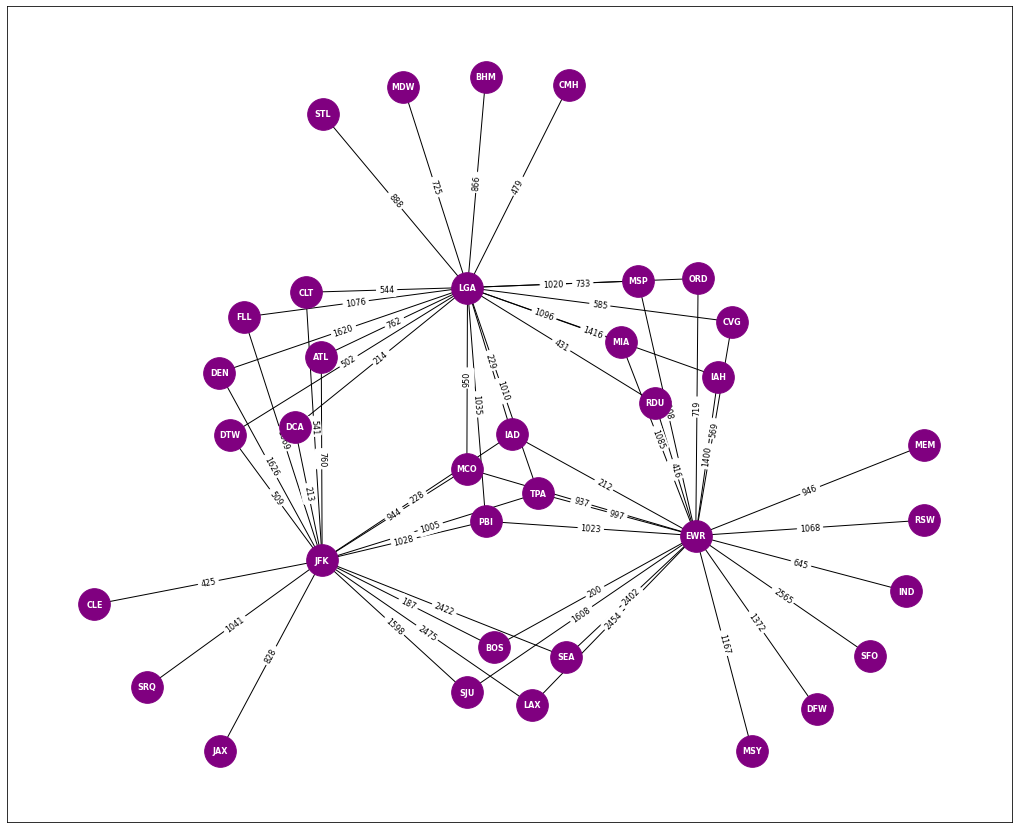

In [30]:
pos = nx.kamada_kawai_layout(FG)

nx.draw_networkx(
    FG,
    pos=pos,
    with_labels=True,
    node_size=1000,
    node_color="purple",
    edge_color="black",
    font_size=8,
    font_color="white",
    font_weight="bold",
)

nx.draw_networkx_edge_labels(
    FG,
    pos=pos,
    edge_labels=nx.get_edge_attributes(FG, "distance"),
    font_size=8,
    font_color="black",
)

plt.show();

As can be seen, there appears to be three airports--- JFK, EWR, and LGA--- all of which are in the greater New York area, that have the most flight arrivals and departures.

### Degree Distribution

The first network metric is the degree distribution. The degree measures the number of edges that are connected to the node. In terms of the adjacency matrix $A$, the degree for a node indexed by $i$ in an undirected network is
$$
k_i=\sum_j a_{i j}
$$
where the sum is over all nodes in the network.

In a directed network, each node has two degrees. The out-degree is the number of outgoing edges emanating from a node
$$
k_i^{\text {out }}=\sum_j a_{j i}
$$
and the in-degree is the number of incoming edges onto a node
$$
k_i^{\mathrm{in}}=\sum_j a_{i j}
$$
The total degree of the node is the sum of its in- and out-degree
$$
k_i^{\text {tot }}=k_i^{\text {in }}+k_i^{\text {out }}
$$

The degrees for all nodes in an undirected graph can be obtained as follows:

In [31]:
degree_sequence = sorted(
    (degree for node, degree in FG.degree()), reverse=True
)  # Decreasing order
max_degree = max(degree_sequence)

FG.degree()

DegreeView({'EWR': 20, 'MEM': 1, 'LGA': 20, 'FLL': 2, 'SEA': 2, 'JFK': 17, 'DEN': 2, 'ORD': 2, 'MIA': 2, 'PBI': 3, 'MCO': 3, 'CMH': 1, 'MSP': 2, 'IAD': 3, 'CLT': 2, 'TPA': 3, 'DCA': 2, 'SJU': 2, 'ATL': 2, 'BHM': 1, 'SRQ': 1, 'MSY': 1, 'DTW': 2, 'LAX': 2, 'JAX': 1, 'RDU': 2, 'MDW': 1, 'DFW': 1, 'IAH': 2, 'SFO': 1, 'STL': 1, 'CVG': 2, 'IND': 1, 'RSW': 1, 'BOS': 2, 'CLE': 1})

We can visualize the degree distribution in two ways:

* Degree Rank Plot

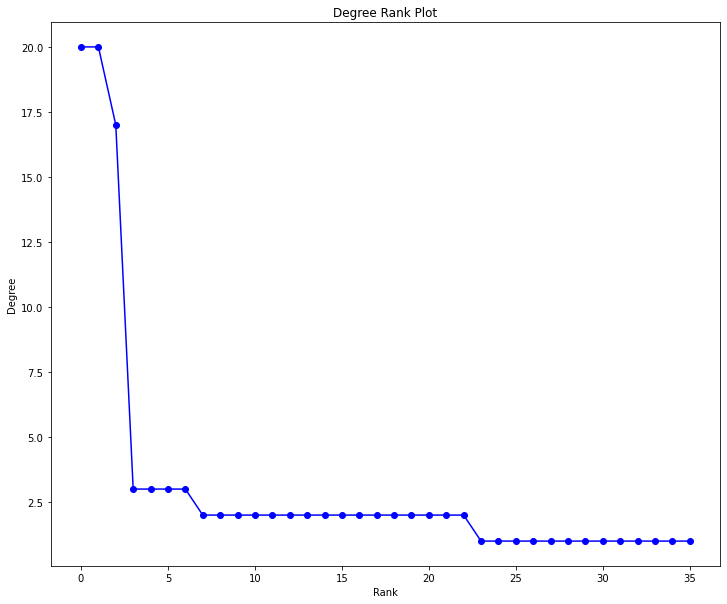

In [32]:
fig, ax = plt.subplots()

ax.plot(degree_sequence, "b-", marker="o")
ax.set_title("Degree Rank Plot")
ax.set_ylabel("Degree")
ax.set_xlabel("Rank")
ax.figure.set_size_inches(12, 10)

plt.show();

* Degree Histogram

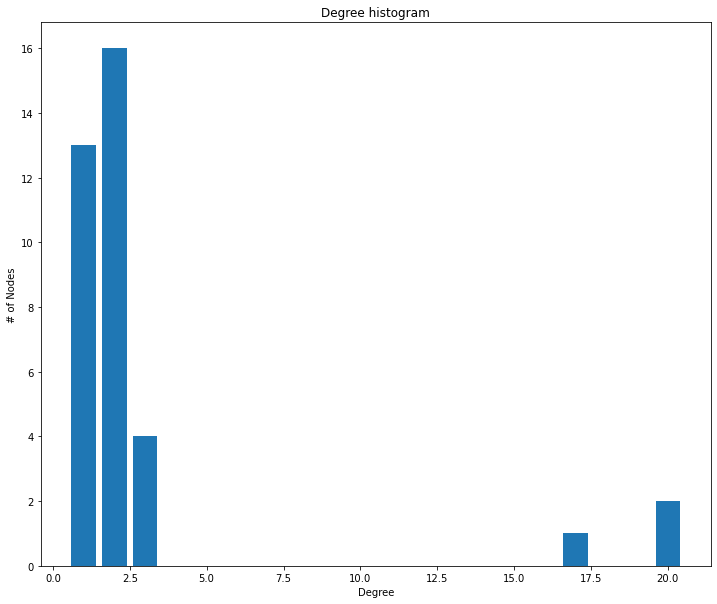

In [33]:
fig, ax = plt.subplots()

ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree histogram")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")
ax.figure.set_size_inches(12, 10)

plt.show();

There definitely are two communities--- one consisting of high degree airports and one consisting of relatively lower degree airports. The distribution of degree is disconnected between the two peaks, meaning that the communities are well separated in terms of node degrees. 

### Density

Density is a measure of the overall connectedness of network data; it focuses on both the edges and the nodes. For undirected graphs, this metric is the ratio of the actual number of edges to the maximum number of potential edges in a network with a fixed number of nodes. Formally, this metric is defined as follows:

$$
\text { density (undirected) }=\frac{e}{n(n-1) / 2}
$$

where $e$ is the number of edges, and $n$ is the number of nodes. This metric ranges between just above 0 (not dense at all) and 1 (as dense as possible).

In [213]:
network_density = len(FG.edges()) / ((len(FG.nodes()) * (len(FG.nodes()) - 1)) / 2)
network_density

0.09047619047619047

### Other Metrics

The **average shortest path length** is
$$
a=\sum_{\substack{s, t \in V \\ s \neq t}} \frac{d(s, t)}{n(n-1)}
$$
where 

* $V$ is the set of nodes in $G$
* $d(s, t)$ is the shortest path distance (number of edges of the shortest path) from $s$ to $t$
* $n$ is the number of nodes in $G$

In [34]:
nx.average_shortest_path_length(FG)

2.36984126984127

The **average degree connectivity** is the average nearest neighbor degree of nodes with degree $k$. For weighted graphs, an analogous measure can be computed using the weighted average neighbors degree defined in A. Barrat, M. Barthélemy, R. Pastor-Satorras, and A. Vespignani (2004), for a node $i$ as
$$
k_{n n, i}^w=\frac{1}{s_i} \sum_{j \in N(i)} w_{i j} k_j
$$
where 
* $s_i$ is the weighted degree of node $i$ 
* $w_{i j}$ is the weight of the edge that links $i$ and $j$
* $N(i)$ are the neighbors of node $i$

This metric answers the question: for a node of degree $k$ (i.e., it has $k$ edges connected to it), what is the average of the degree of this node's neighbors? The value of $k$ is all the possible degrees observed in the network graph. For this example, there are four degrees observed in the graph--- 20, 17, 3, 2, 1.

In [243]:
nx.average_degree_connectivity(FG)

{20: 1.95, 1: 19.307692307692307, 2: 19.0625, 17: 2.0588235294117645, 3: 19.0}

### Dijkstra’s Algorithm

Dijkstra’s algorithm finds the shortest path between nodes in a graph. With the algorithm, we can find the shortest path from a starting node to all the other nodes in the graph. 

It is a type of greedy algorithm. It only works on weighted graphs with positive weights.  

Dijkstra’s algorithm starts at the chosen node (also known as the source node).  The algorithm keeps track of the currently known shortest path from each node to the source node. It updates the path values if it finds a shorter path. When the algorithm finds the shortest path between the source node and another node, that node is marked as “visited” and added to the path. This process continues until all of the nodes have been added to the path. The result of the algorithm is a path that connects the source node to all other nodes in the graph following the shortest path to each node.

This algorithm has a time complexity of $O\left(V^2\right)$ using the adjacency matrix representation of graph. The time complexity can be reduced to $O((V+E) \log V)$ using adjacency list representation of graph, where $E$ is the number of edges in the graph and $V$ is the number of vertices in the graph.

In [36]:
nx.dijkstra_path(
    FG, source="JAX", target="DFW", weight="distance"
)  # Shortest path by distance

['JAX', 'JFK', 'BOS', 'EWR', 'DFW']

In [37]:
nx.dijkstra_path(
    FG, source="JAX", target="DFW", weight="air_time"
)  # Shortest path by air time

['JAX', 'JFK', 'BOS', 'EWR', 'DFW']

Note again that the weights have to be positive.

## Question 2: Maximal Cliques

A clique in an undirected graph $G = (V, E)$ is a subset of the vertex (node) set $C \subset V$ such that, for every two vertices (nodes) in $C$, there exists an edge connecting the two. The connections must all be single edges—a connection via a multi-node path does not count. This is equivalent to saying that the subgraph $H$ induced by $C$ is complete (in some cases, the term clique may also refer to the subgraph).

For each node $n$, a maximal clique for $n$ is a largest complete subgraph containing $n$. The largest maximal clique is sometimes called the maximum clique.

In [38]:
print(
    f"There are {len(list(nx.find_cliques(FG, nodes=None)))} maximal cliques in the graph"
)

There are 57 maximal cliques in the graph


To obtain a list of all maximal cliques, use `list(find_cliques(G))`. However, in the worst-case, the length of this list can be exponential in the number of nodes in the graph. This function avoids storing all cliques in memory by only keeping current candidate node lists in memory during its search. 

### Maximal Cliques

To formalize the concept of "maximal clique" a bit more, let $H$ be a graph induced by $C \subset V$ of $G = (V, E)$. The subgraph $H$ is a **maximal clique** in $G$ if $H$ is isomorphic to a complete graph and there is no vertex $v \in V \backslash C$ so that $v$ is adjacent to every vertex or node of $H$. The notation $v \in V \backslash C$ means that the vertex (node) $v$ is an element of the vertex set of the graph $G$ (denoted $V$) but is not an element of the subset of vertices $H$ (denoted $C$). The symbol $\backslash$ represents the set difference operation, which gives the set of elements in $V$ that are not in $C$.

Put another way, a subgraph $H$ of a graph $G$ is a maximal clique in $G$ if 

* $H$ is a clique (there is an edge between every pair of vertices in the vertex set $C$ of $H$) 
* There is no vertex in $v$ in the vertex set $V$ of $G$ but not in the vertex set $C$ of $H$--- that sends an edge to every vertex of in $C$ of $H$. We cannot create a bigger clique in $G$ by adding another vertex to $H$. 
  
To give an example, the diagram below contains four scenarios:

<center> 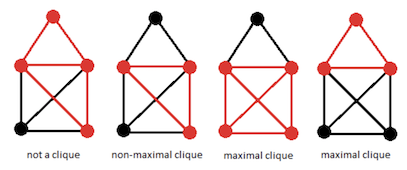 </center> 

* The red subgraph of the first graph is not a clique, because there are two vertices in it not connected by an edge. 
* The red subgraph of the second graph is a clique; however, there is a vertex in the larger graph connected to all 3 vertices in the subgraph, it is not a maximal clique. 
* The red subgraph of the third graph is a maximal clique because it is a clique, and the last vertex not included in the subgraph does not send an edge to every vertex in the subgraph. 
* The red subgraph of the fourth graph is a maximal clique because it is a clique, and neither of the vertices not included in the subgraph send an edge to every vertex in the subgraph. 

Note that the third and fourth red subgraphs are both maximal cliques even though the third red subgraph is larger.

## Question 3: Busiest Airports

We can use three measures to quantify busyness of airports.

* The **degree centrality** for a node $v$ is the fraction of nodes it is connected to.

In [40]:
df_degree_centralities = pd.DataFrame().from_dict(
    nx.degree_centrality(FG), orient="index", columns=["degree_centrality"]
)
df_degree_centralities.sort_values(
    by="degree_centrality", ascending=False, inplace=True
)
df_degree_centralities.head(5)

,degree_centrality
EWR,0.571429
LGA,0.571429
JFK,0.485714
TPA,0.085714
PBI,0.085714


* The **closeness centrality** of a node $u$ is the reciprocal of the average shortest path distance to $u$ over all $n-1$ reachable nodes.

    $$
    C(u)=\frac{n-1}{\sum_{v=1}^{n-1} d(v, u)}
    $$

    where $d(v, u)$ is the shortest-path distance (number of edges of the shortest path) between $v$ and $u$, and $n-1$ is the number of nodes reachable from $u$. Notice that the closeness distance function computes the incoming distance to $u$ for directed graphs. To use outward distance, pass `G.reverse()` to the first keyword argument `G` instead of the original graph object instance. Higher values of closeness indicate higher centrality. The Dijkstra's Algorithm is used to find the shortest path between a given node (which is called the "source node") and all other nodes in a graph.

In [41]:
df_closeness_centralities = pd.DataFrame().from_dict(
    nx.closeness_centrality(FG), orient="index", columns=["closeness_centrality"]
)
df_closeness_centralities.sort_values(
    by="closeness_centrality", ascending=False, inplace=True
)
df_closeness_centralities.head(5)

,closeness_centrality
EWR,0.555556
LGA,0.555556
MCO,0.522388
TPA,0.522388
IAD,0.522388


* Define the **betweenness** of an edge $(u, v)$ to be the number of pairs of nodes $x$ and $y$ such that the edge $(u, v)$ lies on the shortest path between $x$ and $y$. To be more precise, since there can be several shortest paths between $x$ and $y$, edge $(u, v)$ is credited with the fraction of those shortest paths that include the edge $(u, v)$. A high score is bad; this means that the edge between $u$ and $v$ lies on many shortest paths between many pairs of nodes $x$ and $y$. It suggests that the edge $(u, v)$ runs between two different communities; that is, $u$ and $v$ do not belong to the same community. Below is an example:

    <center> 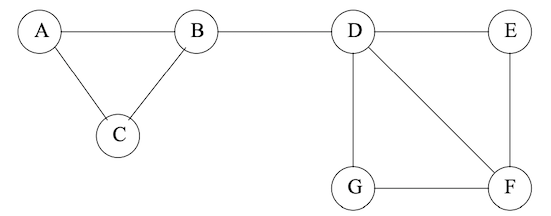 </center> 

    In the figure above, the edge $(B, D)$ has the highest betweenness. In fact, this edge is on every shortest path between any of $A, B$, and $C$ to any of $D, E, F$, and $G$. Its betweenness is therefore $3 \times 4=12$. In contrast, the edge $(D, F)$ is on only four shortest paths: those from $A, B, C$, and $D$ to $F$. We often normalize the betweeness of $u$ and $v$ by dividing it by the number of all possible shortest paths. The number of all posible shortest paths is $\left(\begin{array}{l}n \\ 2 \end{array}\right)=\frac{n(n-1)}{2}$, where $n$ is the number of nodes in the graph.

In [43]:
df_betweenness_centralities = pd.DataFrame().from_dict(
    nx.betweenness_centrality(FG), orient="index", columns=["betweenness_centrality"]
)
df_betweenness_centralities.sort_values(
    by="betweenness_centrality", ascending=False, inplace=True
)
df_betweenness_centralities.head(5)

,betweenness_centrality
EWR,0.447339
LGA,0.409524
JFK,0.309524
MCO,0.030812
TPA,0.030812


The airports that constantly appear in the top 5 are--- EWR, LGA, and TPA. On the other hand, JFK and $MCO$ appear in the top five for two of the three measures of centrality.

## Question 4: New Routes

For identifying new routes, we will assume that the origin destination pairs are symmetric. In the context of delays, I think it makes sense to consider each pair of origin and destination airports as asymmetric; each airport has its own characteristics such as traffic, staffing, and weather condition. However, for recommending new routes (flights) as a strategy, it does not make a lot of sense to consider flights from JFK to EWR a different route than from EWR to JFK. Indeed, while some travelers would opt to book two one-way flights to save on traveling costs, most commercial flights offer two-way tickets that include a returning flight to the origin airport. In other words, if we recommend a new route from, say, EWR to SEA, then it means flights that go both ways.

The code that helps identify new routes below contain the following pieces:

`FG.nodes(data=True)` returns a `NodeDataView` object that contains the node attributes dictionaries for each airport (empty in our case since we did not specify any node attributes):

In [48]:
FG.nodes(data=True)

NodeDataView({'EWR': {}, 'MEM': {}, 'LGA': {}, 'FLL': {}, 'SEA': {}, 'JFK': {}, 'DEN': {}, 'ORD': {}, 'MIA': {}, 'PBI': {}, 'MCO': {}, 'CMH': {}, 'MSP': {}, 'IAD': {}, 'CLT': {}, 'TPA': {}, 'DCA': {}, 'SJU': {}, 'ATL': {}, 'BHM': {}, 'SRQ': {}, 'MSY': {}, 'DTW': {}, 'LAX': {}, 'JAX': {}, 'RDU': {}, 'MDW': {}, 'DFW': {}, 'IAH': {}, 'SFO': {}, 'STL': {}, 'CVG': {}, 'IND': {}, 'RSW': {}, 'BOS': {}, 'CLE': {}})

`FG.neighbors(n)` returns an iterator over all neighbors of node $n$. This is identical to `iter(G[n])`.

In [54]:
list(FG.neighbors("JFK"))

['DEN',
 'SEA',
 'MCO',
 'TPA',
 'SJU',
 'ATL',
 'SRQ',
 'DCA',
 'DTW',
 'LAX',
 'JAX',
 'FLL',
 'CLT',
 'PBI',
 'CLE',
 'IAD',
 'BOS']

In [91]:
# Initialize container ((neighbor_1, neighbor_2) -> combined degree centrality)
new_routes = {}

# Iterate over all the nodes in the graph
for node, node_attr in FG.nodes(data=True):
    # Iterate over all possible pairs of neighbors of 'node'
    for neighbor_1, neighbor_2 in combinations(FG.neighbors(node), 2):
        # If the pair (neighbor_1, neighbor_2) or (neighbor_2, neighbor_1) is already in new_routes, skip it
        if (neighbor_1, neighbor_2) in new_routes.keys() or (
            neighbor_2,
            neighbor_1,
        ) in new_routes.keys():
            continue

        # Check whether 'neighbor_1' and 'neighbor_2' has an edge connecting them to each other
        if not FG.has_edge(neighbor_1, neighbor_2):
            # If no edges (neighbor_1, neighbor_2) exists, compute the combined degree centrality of 'neighbor_1' and 'neighbor_2'
            new_routes[(neighbor_1, neighbor_2)] = float(
                df_degree_centralities.loc[neighbor_1]
            ) + float(df_degree_centralities.loc[neighbor_2])

Next, we identify the top six pairs of origin-destination that have the highest combined degree centralities; these are the recommended new routes:

In [132]:
degree_centralities_sorted = sorted(new_routes.values())
recommended_new_routes = [
    origin_dest_pair
    for origin_dest_pair, combined_centrality in new_routes.items()
    if combined_centrality > np.unique(degree_centralities_sorted)[-4]
]
recommended_new_routes

[('TPA', 'IAD'),
 ('TPA', 'PBI'),
 ('TPA', 'MCO'),
 ('IAD', 'PBI'),
 ('IAD', 'MCO'),
 ('PBI', 'MCO'),
 ('LGA', 'JFK'),
 ('EWR', 'JFK'),
 ('LGA', 'EWR')]

Any of the 9 pairs of origin and destination have combined degree centrality greater than $0.1429$, which is the fourth highest combined degree centrality out of all pairs. Note that we could have also used other centrality measures--- closeness and betweenness.

In [129]:
# Initialize container ((neighbor_1, neighbor_2) -> combined degree centrality)
new_routes_closeness = {}

# Iterate over all the nodes in the graph
for node, node_attr in FG.nodes(data=True):
    # Iterate over all possible pairs of neighbors of 'node'
    for neighbor_1, neighbor_2 in combinations(FG.neighbors(node), 2):
        # If the pair (neighbor_1, neighbor_2) or (neighbor_2, neighbor_1) is already in new_routes, skip it
        if (neighbor_1, neighbor_2) in new_routes_closeness.keys() or (
            neighbor_2,
            neighbor_1,
        ) in new_routes_closeness.keys():
            continue

        # Check whether 'neighbor_1' and 'neighbor_2' has an edge connecting them to each other
        if not FG.has_edge(neighbor_1, neighbor_2):
            # If no edges (neighbor_1, neighbor_2) exists, compute the combined degree centrality of 'neighbor_1' and 'neighbor_2'
            new_routes_closeness[(neighbor_1, neighbor_2)] = float(
                df_closeness_centralities.loc[neighbor_1]
            ) + float(df_closeness_centralities.loc[neighbor_2])

In [133]:
closeness_centralities_sorted = sorted(new_routes_closeness.values())
recommended_new_routes_closeness = [
    origin_dest_pair
    for origin_dest_pair, combined_centrality in new_routes_closeness.items()
    if combined_centrality > np.unique(closeness_centralities_sorted)[-4]
]
recommended_new_routes_closeness

[('TPA', 'IAD'),
 ('TPA', 'PBI'),
 ('TPA', 'MCO'),
 ('IAD', 'PBI'),
 ('IAD', 'MCO'),
 ('PBI', 'MCO'),
 ('LGA', 'JFK'),
 ('EWR', 'JFK'),
 ('LGA', 'EWR')]

In [136]:
# Initialize container ((neighbor_1, neighbor_2) -> combined degree centrality)
new_routes_between = {}

# Iterate over all the nodes in the graph
for node, node_attr in FG.nodes(data=True):
    # Iterate over all possible pairs of neighbors of 'node'
    for neighbor_1, neighbor_2 in combinations(FG.neighbors(node), 2):
        # If the pair (neighbor_1, neighbor_2) or (neighbor_2, neighbor_1) is already in new_routes, skip it
        if (neighbor_1, neighbor_2) in new_routes_between.keys() or (
            neighbor_2,
            neighbor_1,
        ) in new_routes_between.keys():
            continue

        # Check whether 'neighbor_1' and 'neighbor_2' has an edge connecting them to each other
        if not FG.has_edge(neighbor_1, neighbor_2):
            # If no edges (neighbor_1, neighbor_2) exists, compute the combined degree centrality of 'neighbor_1' and 'neighbor_2'
            new_routes_between[(neighbor_1, neighbor_2)] = float(
                df_betweenness_centralities.loc[neighbor_1]
            ) + float(df_betweenness_centralities.loc[neighbor_2])

In [138]:
between_centralities_sorted = sorted(new_routes_between.values())
recommended_new_routes_between = [
    origin_dest_pair
    for origin_dest_pair, combined_centrality in new_routes_between.items()
    if combined_centrality > np.unique(between_centralities_sorted)[-5]
]
recommended_new_routes_between

[('TPA', 'IAD'),
 ('TPA', 'PBI'),
 ('TPA', 'MCO'),
 ('IAD', 'PBI'),
 ('IAD', 'MCO'),
 ('PBI', 'MCO'),
 ('LGA', 'JFK'),
 ('EWR', 'JFK'),
 ('LGA', 'EWR')]

Based on these centrality measures, we recommend the following six new routes:

* ('TPA', 'IAD')

* ('TPA', 'PBI')

* ('LGA', 'EWR')

* ('LGA', 'JFK')

* ('IAD', 'MCO')

* ('EWR', 'JFK')